# DM-27798: Saha Crowded Field ap_pipe run for Ian

I ran `ap_pipe` on the DECam Saha Bulge dataset using 2015 as template and 2013 as science. The output repo is `/project/mrawls/saha/ap_pipe/cw_2013` and the APDB is in the `lsstdevapdb1` postgres, schema `mrawls_dec2020_saha`.

This notebook is an initial quick look at the results of the run.

In [2]:
%matplotlib notebook

import sys
import numpy as np
import matplotlib.pyplot as plt
import importlib
import pandas as pd

import lsst.daf.persistence as dafPersist

plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
sys.path.append('/project/mrawls/ap_pipe-notebooks/')
import diaObjectAnalysis as doa
import apdbPlots as pla

In [3]:
# Only if you change anything in the code imported above
importlib.reload(doa)
importlib.reload(pla)

<module 'apdbPlots' from '/project/mrawls/ap_pipe-notebooks/apdbPlots.py'>

In [4]:
repo = '/project/mrawls/saha/ap_pipe/cw_2013'

In [5]:
import psycopg2
dbName = 'lsstdevapdb1'
host = 'lsst-pg-devel1.ncsa.illinois.edu'
schema = 'mrawls_dec2020_saha'
connection = psycopg2.connect(dbname=dbName, host=host, options=f'-c search_path={schema}')

In [6]:
tables = {'obj': '"DiaObject"', 'src': '"DiaSource"',
          'sso': '"SSObject"', 'forcedsrc': '"DiaForcedSource"',
          'proto': '"ApdbProtoVisits"', 'match': '"DiaObject_To_Object_Match"'}

In [7]:
objTable = pd.read_sql_query('select "diaObjectId", "ra", "decl", "nDiaSources", \
                              "gPSFluxMean", "rPSFluxMean", "iPSFluxMean", \
                              "zPSFluxMean", "yPSFluxMean", "validityEnd", "flags" from {0} \
                              where "validityEnd" is NULL;'.format(tables['obj']), connection)

In [8]:
srcTable = pd.read_sql_query('select "diaSourceId", "diaObjectId", \
                              "ra", "decl", "ccdVisitId", \
                              "midPointTai", "apFlux", "psFlux", "apFluxErr", \
                              "psFluxErr", "totFlux", "totFluxErr", "x", "y", \
                              "ixxPSF", "ixyPSF", "flags", "filterName" from {0}; \
                              '.format(tables['src']), connection)

In [9]:
srcTable = pla.addVisitCcdToSrcTable(srcTable)

In [10]:
flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = pla.makeSrcTableFlags(srcTable, objTable)

<IPython.core.display.Javascript object>


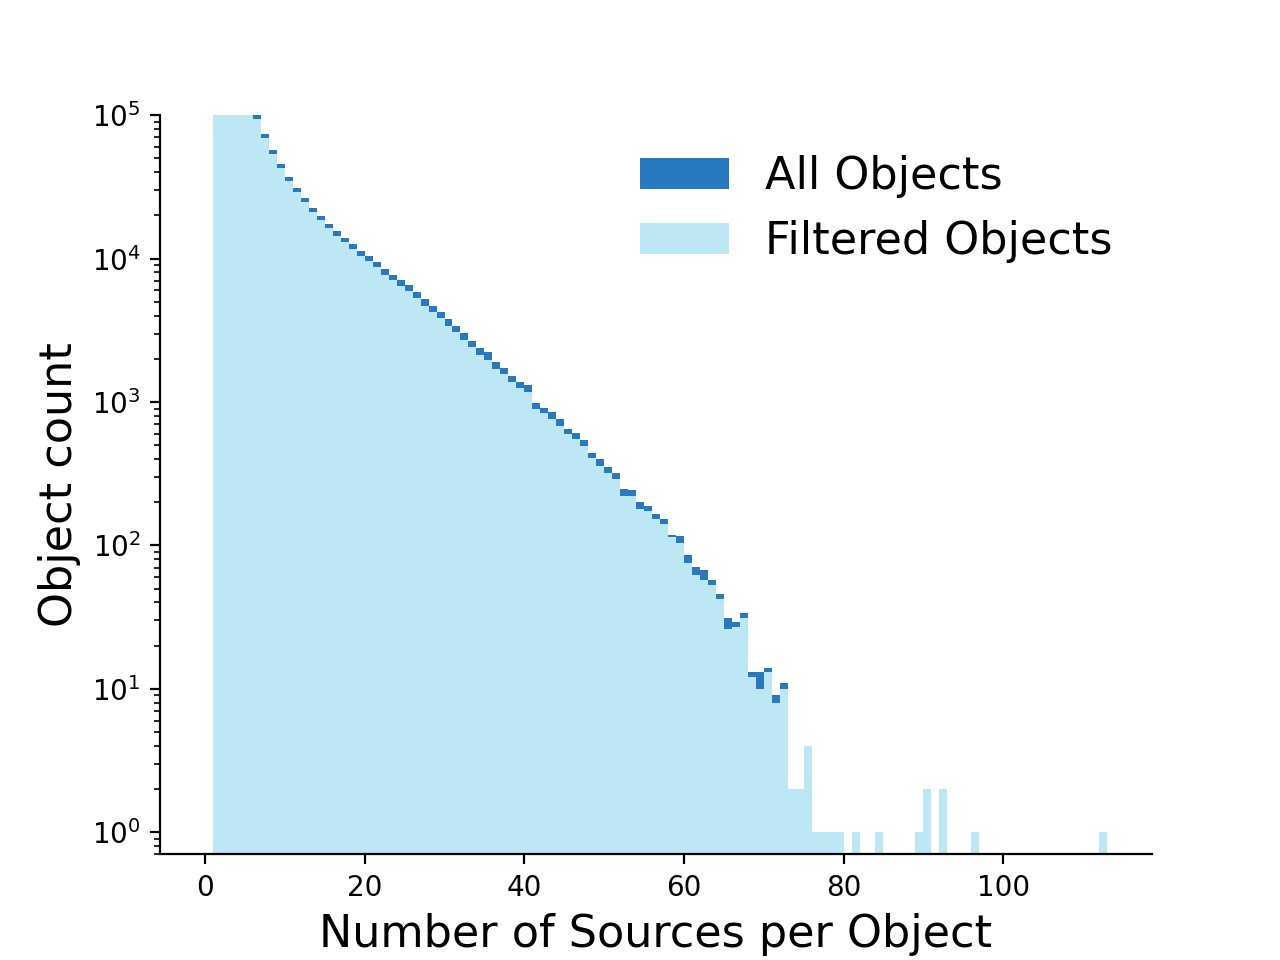

In [11]:
hist = doa.plotDiaObjectHistogram(objTable, goodObj)

<IPython.core.display.Javascript object>


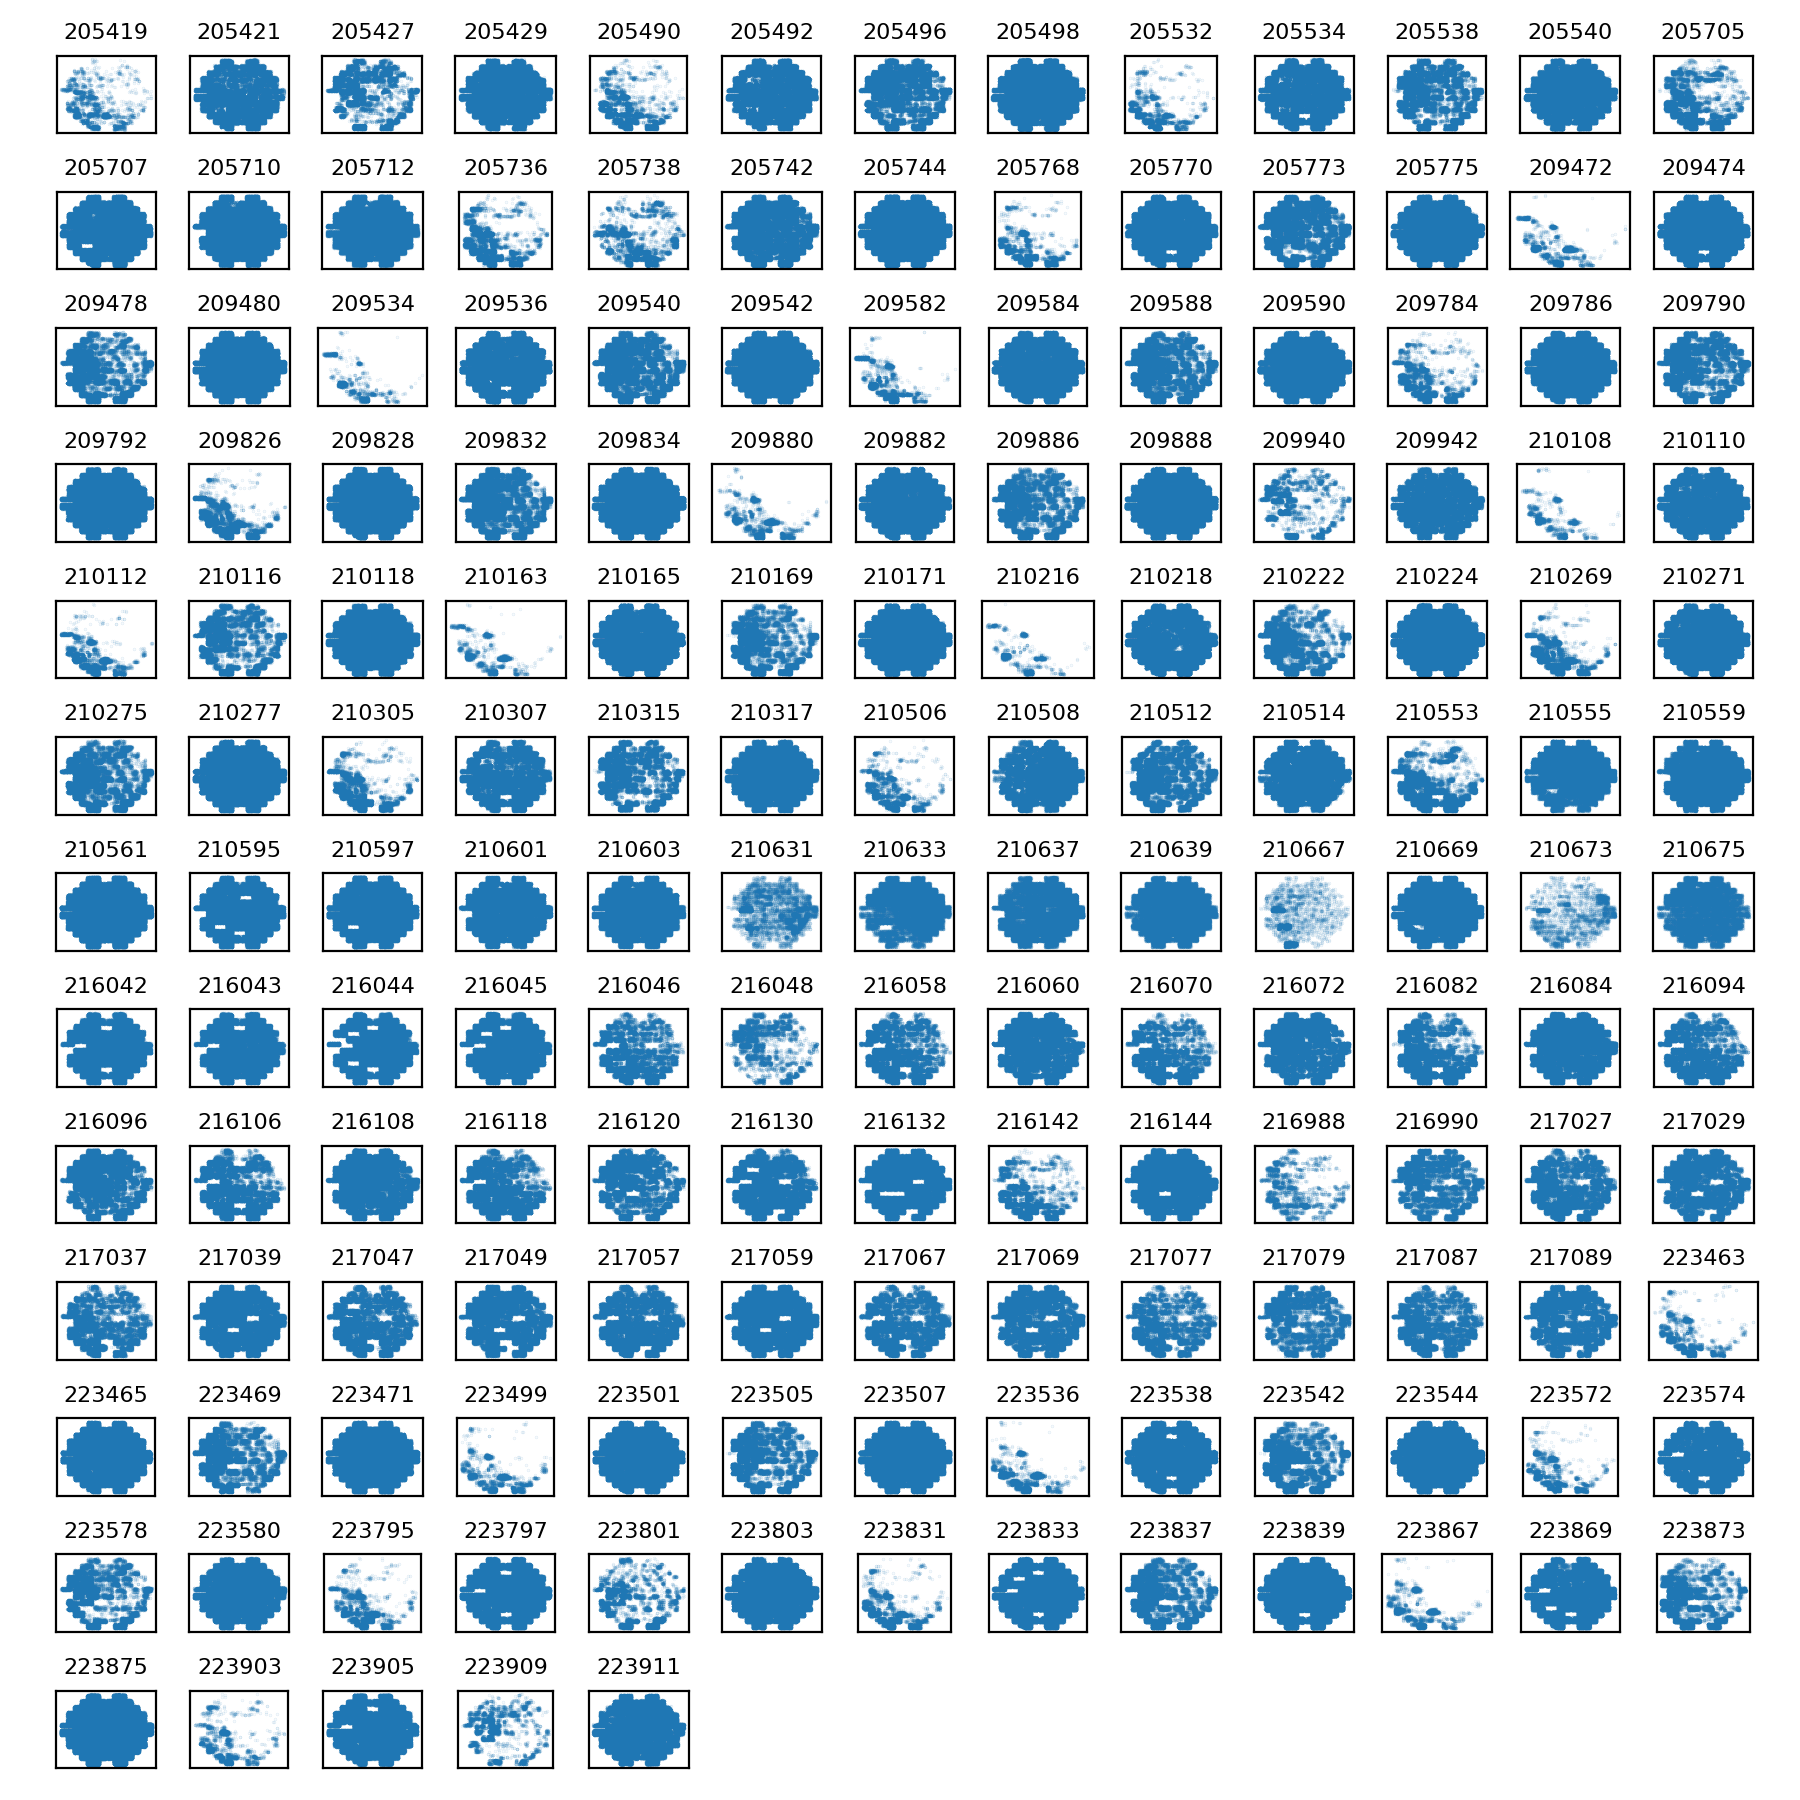

In [12]:
pla.plotDiaSourcesOnSkyGrid(repo, goodSrc)

In [13]:
#pla.plotDiaSourcesInFocalPlane(repo, srcTable)  # extremely slow for such a dense field

In [13]:
def plotFluxHistSrc(srcTable1, srcTable2=None, fluxType='psFlux', label1=None, label2=None, title=None, ylog=False):
    plt.figure(figsize=(7, 5))
    plt.xlabel(fluxType, size=12)
    plt.ylabel('DIA Source count', size=12)
    #bins = np.concatenate((-1*np.flip(np.logspace(-1, 6, 50)), np.logspace(-1, 6, 50)))
    bins = np.linspace(-1e4, 1e4, 200)
    if ylog:
        plt.yscale('log')
    #plt.xscale('symlog')
    plt.hist(srcTable1[fluxType].values, bins=bins, color='#2979C1', label=label1)
    if srcTable2 is not None:
        plt.hist(srcTable2[fluxType].values, bins=bins, color='#Bee7F5', label=label2)
    if label1:
        plt.legend(frameon=False, fontsize=12)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.title(title)

<IPython.core.display.Javascript object>


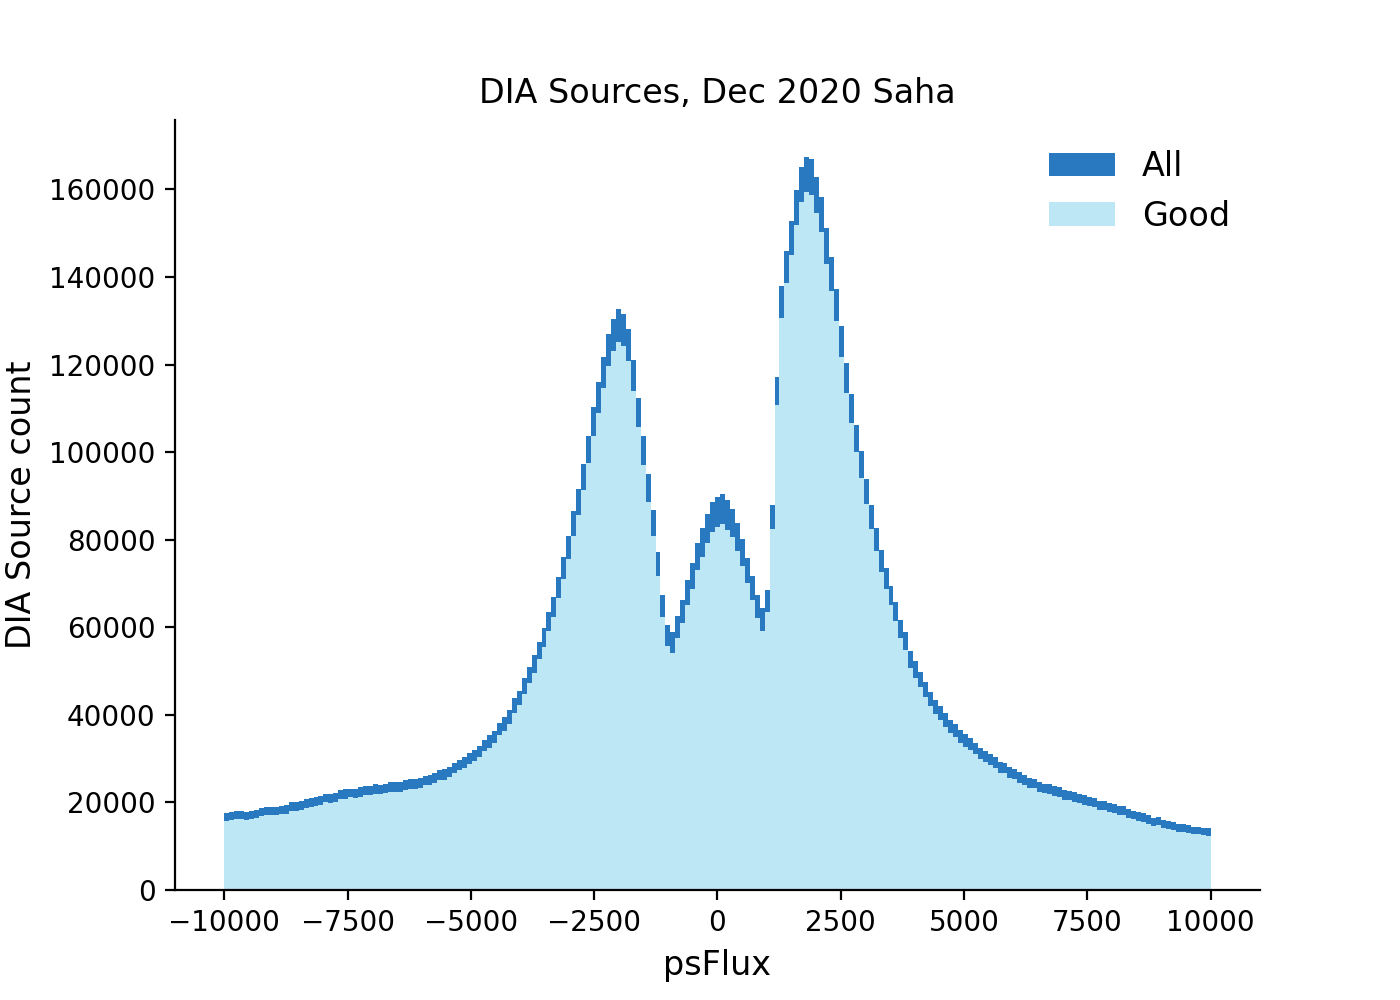

In [14]:
plotFluxHistSrc(srcTable, goodSrc, fluxType='psFlux', label1='All', label2='Good',
                title='DIA Sources, Dec 2020 Saha')

<IPython.core.display.Javascript object>


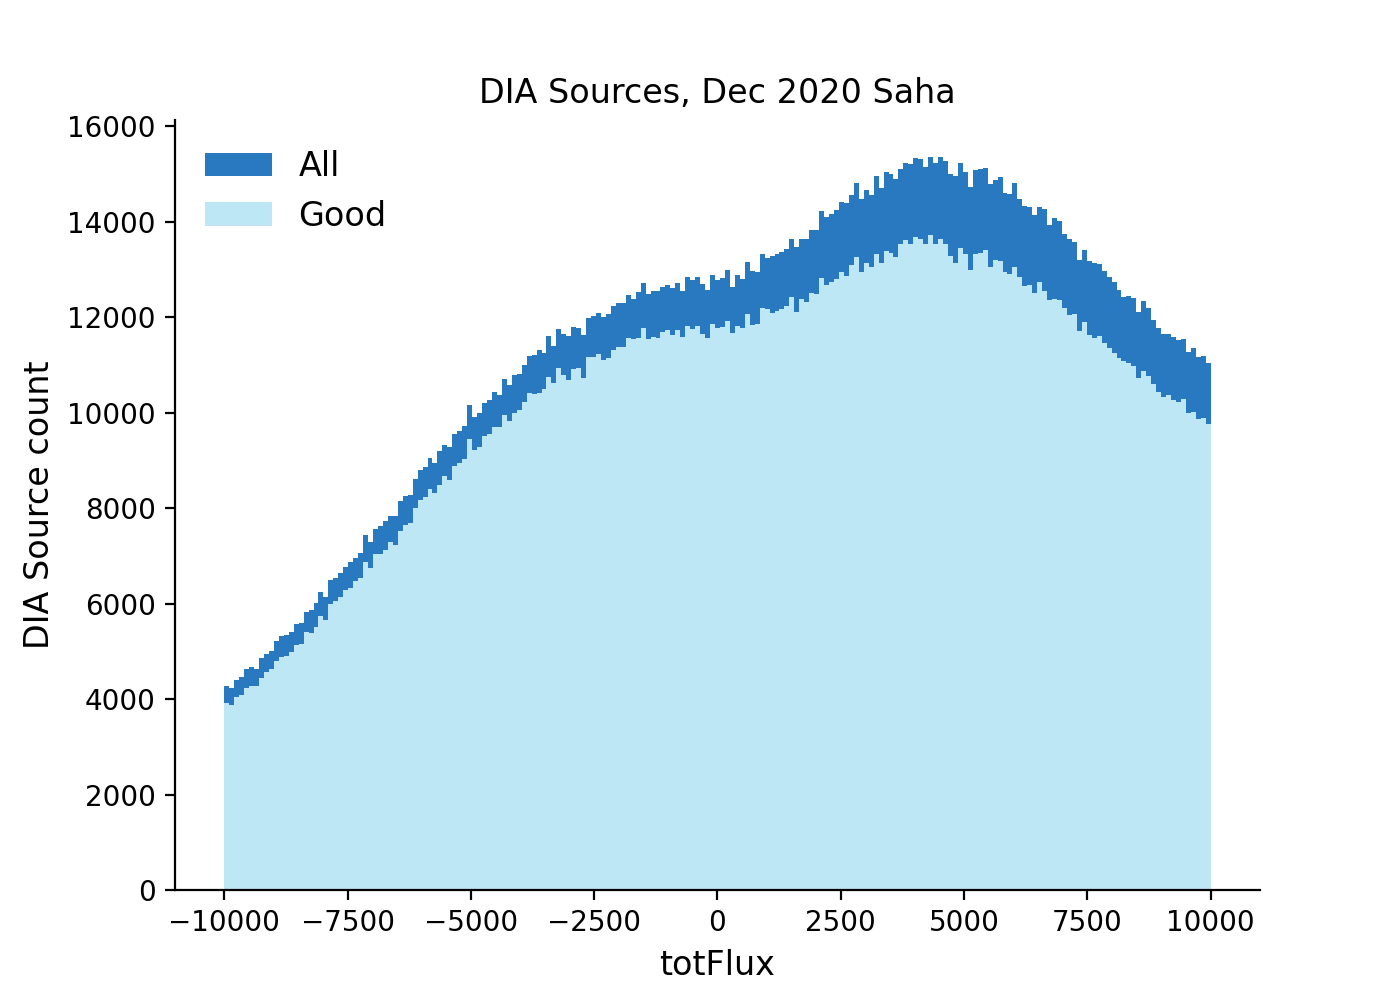

In [15]:
plotFluxHistSrc(srcTable, goodSrc, fluxType='totFlux', label1='All', label2='Good',
                title='DIA Sources, Dec 2020 Saha')

<IPython.core.display.Javascript object>


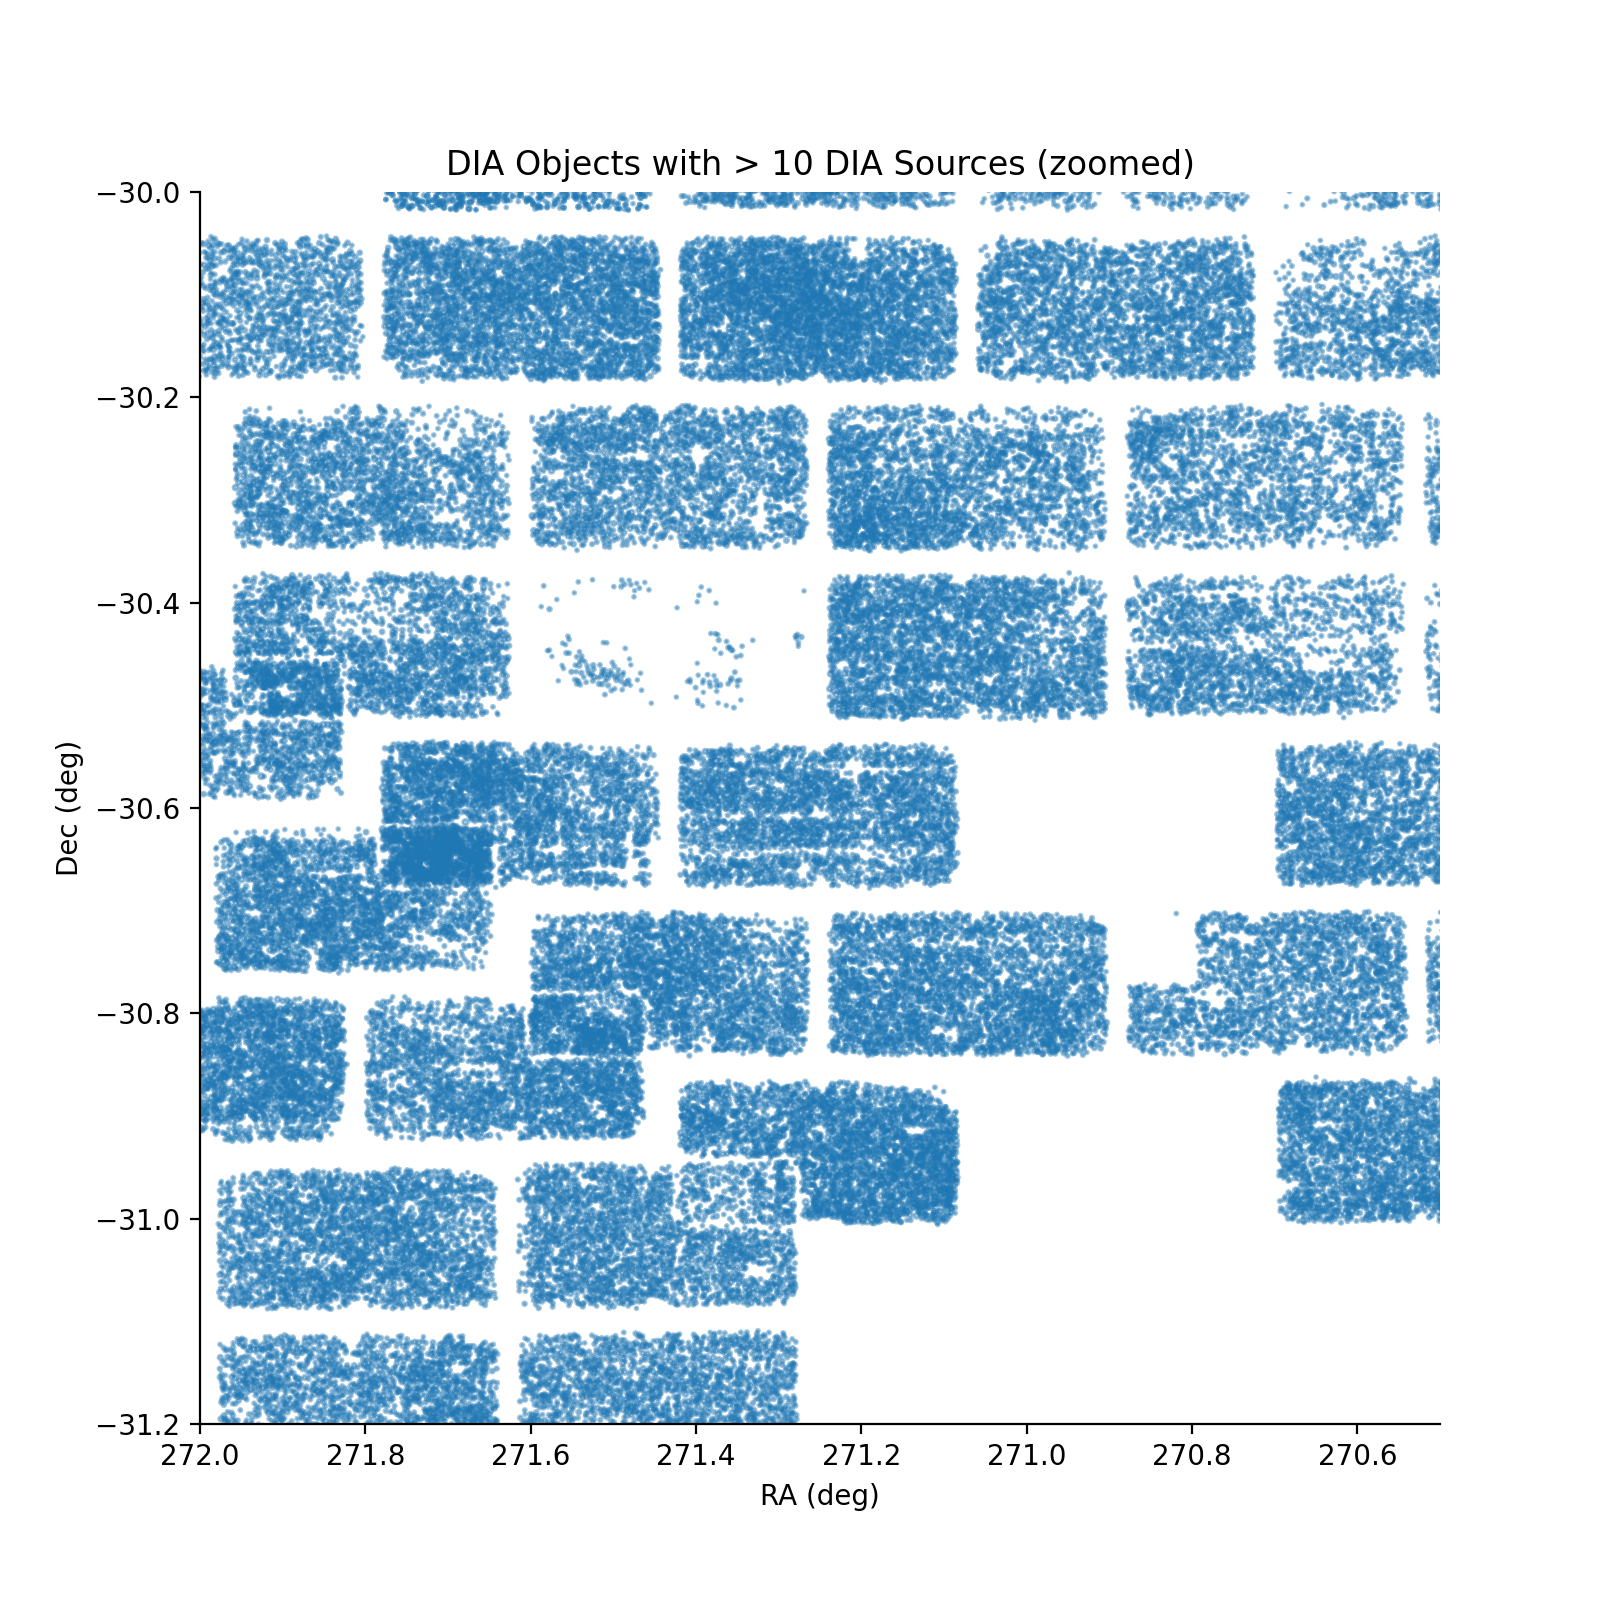

Text(0.5, 1.0, 'DIA Objects with > 10 DIA Sources (zoomed)')

In [27]:
fig = plt.figure(figsize=(8,8))

xlim = (272, 270.5)
ylim = (-31.2, -30.0)
cutoff = 10  # only plot DIA Objects composed of cutoff or more DIA Sources

ax = fig.add_subplot(111)
plt.setp(ax, xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj.loc[goodObj['nDiaSources'] > cutoff, 'ra'], goodObj.loc[goodObj['nDiaSources'] > cutoff, 'decl'], 
           c='C0', s=goodObj.loc[goodObj['nDiaSources'] > cutoff, 'nDiaSources']/10, marker='o', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title('DIA Objects with > {0} DIA Sources (zoomed)'.format(cutoff))